In [1]:
import h5py
import numpy as np
from minimum_image_kernels import RBF
from scipy.sparse.linalg import aslinearoperator
import sys
sys.path.append("../../")
from DynamicalSystems.reduced_rank_regression import reduced_rank_regression
import matplotlib.pyplot as plt

In [2]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print (f"    {key}: {val}")
chignolin_path = '../../../data/md_datasets/chignolin-unbiased/CLN025-0-protein-ALL.h5'
f = h5py.File(chignolin_path, 'r')

In [29]:
dists = f['coordinates'][::20, :,:]
timesteps, n_atoms, dims = dists.shape
dists = dists.reshape(timesteps, n_atoms*dims)
unit_cell_length = f['cell_lengths'][0,0]

In [30]:
kernel = RBF(length_scale=10, unit_cell_length=unit_cell_length)

In [27]:
D = aslinearoperator(kernel(dists, backend='keops'))
D = D@np.eye(D.shape[0], dtype=D.dtype)

[pyKeOps] Compiling libKeOpsnumpyd57aa350d5 in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction((Exp((Minus(Square(Sqrt(Sum(Square(((Var(0,498,0) - Var(1,498,1)) - (Var(3,1,2) * Round(((Var(0,498,0) - Var(1,498,1)) / Var(2,1,2)),0)))))))) / IntCst(200))) * Var(4,1,1)),0)
       aliases: Var(0,498,0); Var(1,498,1); Var(2,1,2); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.


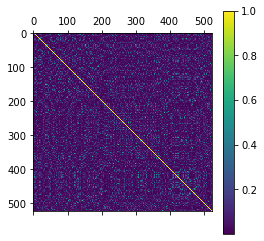

In [28]:
plt.matshow(D)
plt.colorbar()

In [31]:
inputs = dists[:-1]
evolved_inputs=dists[1:]

In [32]:
evals, evecs = reduced_rank_regression(inputs, evolved_inputs, kernel, 10, regularizer=1e-1, backend='keops')

[pyKeOps] Compiling libKeOpsnumpy78e009fef3 in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(((Exp((Minus(Square(Sqrt(Sum(Square(((Var(0,498,0) - Var(1,498,1)) - (Var(3,1,2) * Round(((Var(0,498,0) - Var(1,498,1)) / Var(2,1,2)),0)))))))) / IntCst(200))) / IntCst(26237)) * Var(4,1,1)),0)
       aliases: Var(0,498,0); Var(1,498,1); Var(2,1,2); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpsnumpyc0c7e4655e in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(ComplexScal(Real2Complex((Exp((Minus(Square(Sqrt(Sum(Square(((Var(0,498,0) - Var(1,498,1)) - (Var(3,1,2) * Round(((Var(0,498,0) - Var(1,498,1)) / Var(2,1,2)),0)))))))) / IntCst(200))) / IntCst(26237))), Var(4,2,1)),0)
       aliases: Var(0,498,0); Var(1,498,1); Var(2,1,2); Var(3,1,2); Var(4,2,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpsnumpyc09a9525a4 in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_

(-0.025517717027105393,
 0.44279782616067676,
 -0.005006465339101851,
 0.0049293783726170656)

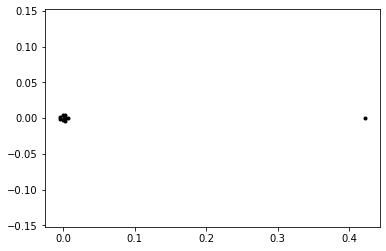

In [34]:
plt.plot(np.real(evals), np.imag(evals), 'k.')
plt.axis("equal")

In [49]:
CVs = aslinearoperator(kernel(inputs, backend='keops'))@evecs
CVs = np.abs(CVs)

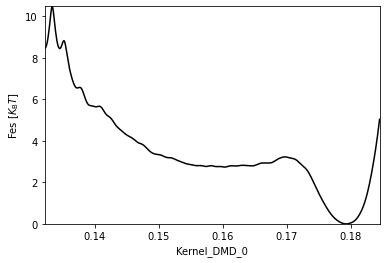

In [71]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
def f(x):
    kde = gaussian_kde(CVs[:,x][:,np.newaxis], bandwidth=0.0005)
    bounds = (CVs[:,x].min(),CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 500)[:,np.newaxis]
    fes = -kde.logpdf(cv_sample)
    fes = fes - fes.min()
    plt.plot(cv_sample, fes, 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")
    full_fes = -kde.logpdf(CVs[:,x][:,np.newaxis])
    return full_fes - full_fes.min()
fes = f(0)

In [72]:
CVs[:,0]

array([0.17887408, 0.1782192 , 0.17653395, ..., 0.16219567, 0.15651083,
       0.17019448], dtype=float32)

In [74]:
fes < 1

array([ True,  True,  True, ..., False, False, False])

In [75]:
CVs[:,0]

array([0.17887408, 0.1782192 , 0.17653395, ..., 0.16219567, 0.15651083,
       0.17019448], dtype=float32)